In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [0]:
# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link_news = 'https://drive.google.com/open?id=1m27dY61RYh3Dk9uxe_idITMI3uN32CHx'
link_price = 'https://drive.google.com/open?id=1C_oMK5Gk1F_aiHxyNc0L-cQg51CqdwIV'

In [0]:
_, id_news = link_news.split('=')
_, id_price = link_price.split('=')

In [0]:
downloaded = drive.CreateFile({'id':id_news}) 
downloaded.GetContentFile('unagg_ffill_news.csv')  

In [0]:
downloaded = drive.CreateFile({'id':id_price}) 
downloaded.GetContentFile('unagg_ffill_price.csv')  

In [0]:
news = pd.read_csv('unagg_ffill_news.csv', index_col = 0)
price = pd.read_csv('unagg_ffill_price.csv', index_col = 0)

In [8]:
news.head()

,ticker,event_impact_gt_mu_pos_add_sigma_pos_avg,event_impact_gt_mu_pos_add_sigma_pos_sum,event_impact_gt_mu_pos_add_sigma_pos_min,event_impact_gt_mu_pos_add_sigma_pos_max,event_impact_lt_mu_sub_sigma_avg,event_impact_lt_mu_sub_sigma_sum,event_impact_lt_mu_sub_sigma_min,event_impact_lt_mu_sub_sigma_max,event_impact_lt_mu_neg_sub_sigma_neg_avg,event_impact_lt_mu_neg_sub_sigma_neg_sum,event_impact_lt_mu_neg_sub_sigma_neg_min,event_impact_lt_mu_neg_sub_sigma_neg_max,entity_source_republish_score_avg,entity_source_republish_score_sum,entity_source_republish_score_min,entity_source_republish_score_max,event_source_timeliness_score_avg,event_source_timeliness_score_sum,event_source_timeliness_score_min,event_source_timeliness_score_max,event_impact_pct_change_avg_avg,event_impact_pct_change_avg_sum,event_impact_pct_change_avg_min,event_impact_pct_change_avg_max,story_group_traffic_sum_avg,story_group_traffic_sum_sum,story_group_traffic_sum_min,story_group_traffic_sum_max,overall_source_timeliness_score_avg,overall_source_timeliness_score_sum,overall_source_timeliness_score_min,overall_source_timeliness_score_max,event_impact_lt_1pct_neg_avg,event_impact_lt_1pct_neg_sum,event_impact_lt_1pct_neg_min,event_impact_lt_1pct_neg_max,story_traffic_avg,story_traffic_sum,story_traffic_min,...,story_group_count_avg,story_group_count_sum,story_group_count_min,story_group_count_max,event_relevance_avg,event_relevance_sum,event_relevance_min,event_relevance_max,event_impact_gt_1pct_pos_avg,event_impact_gt_1pct_pos_sum,event_impact_gt_1pct_pos_min,event_impact_gt_1pct_pos_max,event_impact_lt_mu_neg_sub_2sigma_neg_avg,event_impact_lt_mu_neg_sub_2sigma_neg_sum,event_impact_lt_mu_neg_sub_2sigma_neg_min,event_impact_lt_mu_neg_sub_2sigma_neg_max,event_author_republish_score_avg,event_author_republish_score_sum,event_author_republish_score_min,event_author_republish_score_max,event_source_republish_score_avg,event_source_republish_score_sum,event_source_republish_score_min,event_source_republish_score_max,overall_author_republish_score_avg,overall_author_republish_score_sum,overall_author_republish_score_min,overall_author_republish_score_max,event_sentiment_avg,event_sentiment_sum,event_sentiment_min,event_sentiment_max,entity_relevance_avg,entity_relevance_sum,entity_relevance_min,entity_relevance_max,count,day,hour,dayofwork
0,AAPL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,44.081467,132.2444,41.8747,48.2883,0.0399,0.1197,0.0045,0.0576,1.826834e+11,5.480502e+11,3927884.0,5.459995e+11,50.182067,150.5462,49.0802,50.7330,0.0,0.0,0.0,0.0,17420247.0,52260741.0,3927884.0,...,227.0,681.0,1.0,664.0,68.8,206.4,38.0,99.9,11.111133,33.3334,0.0,16.6667,0.0,0.0,0.0,0.0,0.991267,2.9738,0.0000,2.7946,1.4719,4.4157,1.0416,2.0318,0.985133,2.9554,0.0000,2.2690,24.066667,72.2,0.0,43.8,96.666667,290.0,90.0,100.0,3.0,2014-01-03,0,5
1,AAPL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,44.081467,132.2444,41.8747,48.2883,0.0399,0.1197,0.0045,0.0576,1.826834e+11,5.480502e+11,3927884.0,5.459995e+11,50.182067,150.5462,49.0802,50.7330,0.0,0.0,0.0,0.0,17420247.0,52260741.0,3927884.0,...,227.0,681.0,1.0,664.0,68.8,206.4,38.0,99.9,11.111133,33.3334,0.0,16.6667,0.0,0.0,0.0,0.0,0.991267,2.9738,0.0000,2.7946,1.4719,4.4157,1.0416,2.0318,0.985133,2.9554,0.0000,2.2690,24.066667,72.2,0.0,43.8,96.666667,290.0,90.0,100.0,3.0,2014-01-03,1,5
2,AAPL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7061,0.7061,0.7061,0.7061,34.793300,34.7933,34.7933,34.7933,0.0054,0.0054,0.0054,0.0054,1.471454e+07,1.471454e+07,14714537.0,1.471454e+07,48.244200,48.2442,48.2442,48.2442,0.0,0.0,0.0,0.0,14714537.0,14714537.0,14714537.0,...,1.0,1.0,1.0,1.0,93.0,93.0,93.0,93.0,0.000000,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.344400,0.3444,0.3444,0.3444,1.1012,1.1012,1.1012,1.1012,0.401200,0.4012,0.4012,0.4012,-15.000000,-15.0,-15.0,-15.0,100.000000,100.0,100.0,100.0,1.0,2014-01-03,2,5
3,AAPL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7061,0.7061,0.70

In [0]:
ffill = news.merge(price, how = 'left', on = ['ticker', 'day'])

In [0]:
ffill.drop(['date_x', 'date_y', 'open_price_change'], axis = 1, inplace = True)

In [0]:
ffill.fillna(method = 'ffill', inplace = True)

In [0]:
ffill_train = ffill[pd.to_datetime(ffill['day']) <= datetime.datetime(2017,5,3)]
ffill_validation = ffill[(pd.to_datetime(ffill['day']) >= datetime.datetime(2017,5,4)) & \
                                 (pd.to_datetime(ffill['day']) <= datetime.datetime(2018,4,4))]
ffill_test = ffill[pd.to_datetime(ffill['day']) >= datetime.datetime(2018,4,5)]

In [0]:
ffill_train.reset_index(drop = True, inplace = True)
ffill_validation.reset_index(drop = True, inplace = True)
ffill_test.reset_index(drop = True, inplace = True)

In [0]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(ffill_train.drop(['ticker', 'day', 'hour', 'dayofwork'], axis = 1))
std_train = pd.DataFrame(std.transform(ffill_train.drop(['ticker', 'day', 'hour', 'dayofwork'], axis = 1)), \
                          columns = list(ffill_train.columns[1:142]) + list(ffill_train.columns[145:151]))
std_val = pd.DataFrame(std.transform(ffill_validation.drop(['ticker', 'day', 'hour', 'dayofwork'], axis = 1)),\
                        columns = list(ffill_train.columns[1:142]) + list(ffill_train.columns[145:151]))
std_test = pd.DataFrame(std.transform(ffill_test.drop(['ticker', 'day', 'hour', 'dayofwork'], axis = 1)), \
                         columns = list(ffill_train.columns[1:142]) + list(ffill_train.columns[145:151]))

In [0]:
std_train = std_train.merge(ffill_train[['ticker','day', 'hour', 'dayofwork']], left_index = True, right_index = True)
std_val = std_val.merge(ffill_validation[['ticker','day', 'hour', 'dayofwork']], left_index = True, right_index = True)
std_test = std_test.merge(ffill_test[['ticker','day', 'hour', 'dayofwork']], left_index = True, right_index = True)

In [0]:
from torch.utils.data import Dataset, DataLoader
import torch

class TensoredDataset(Dataset):
    def __init__(self, news, price):
        self.input_tensors = []
        self.target_tensors = []
        
        for ticker in news['ticker'].unique():
            for i, day in enumerate(news['day'].unique()[:-1]):
                second_day = str(datetime.datetime.strptime(day, '%Y-%m-%d').date() + datetime.timedelta(days=1))
                third_day = str(datetime.datetime.strptime(day, '%Y-%m-%d').date() + datetime.timedelta(days=2)) 
                
                input_array = news[(news['ticker'] == ticker) & (news['day'].isin([day, second_day]))].iloc[8:32]
                self.input_tensors.append(torch.from_numpy(input_array.drop(['ticker', 'day', 'hour', 'dayofwork'], axis = 1).values))
                
                if input_array['dayofwork'].unique()[0] <= 5:
                    target_array = price[(price['ticker'] == ticker) & (price['day'] == day)]['open_price_change']
                    self.target_tensors.append(torch.from_numpy(target_array.values))
                elif input_array['dayofwork'].unique()[0] == 6:
                    target_array = price[(price['ticker'] == ticker) & (price['day'] == third_day)]['open_price_change']
                    self.target_tensors.append(torch.from_numpy(target_array.values))                    
                elif input_array['dayofwork'].unique()[0] == 7:
                    target_array = price[(price['ticker'] == ticker) & (price['day'] == second_day)]['open_price_change']
                    self.target_tensors.append(torch.from_numpy(target_array.values))                
                
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        return (self.input_tensors[idx], self.target_tensors[idx])

In [0]:
class WindowTensoredDataset(Dataset):
    def __init__(self, news, price):
        self.input_tensors = []
        self.target_tensors = []
        
        for ticker in news['ticker'].unique():
            for i, day in enumerate(news['day'].unique()[:-2]):
                second_day = str(datetime.datetime.strptime(day, '%Y-%m-%d').date() + datetime.timedelta(days=1))
                third_day = str(datetime.datetime.strptime(day, '%Y-%m-%d').date() + datetime.timedelta(days=2)) 
                fourth_day = str(datetime.datetime.strptime(day, '%Y-%m-%d').date() + datetime.timedelta(days=3))
                
                input_array = news[(news['ticker'] == ticker) & (news['day'].isin([day, second_day, third_day]))].iloc[9:56]
                input_tensor = torch.from_numpy(input_array.drop(['ticker', 'day', 'hour', 'dayofwork'], axis = 1).values)
                input_window_array = input_tensor.unfold(0,24,1)
                for window_array in input_window_array:
                    self.input_tensors.append(window_array.T)
                
                if input_array['dayofwork'].unique()[1] <= 5:
                    target_array = price[(price['ticker'] == ticker) & (price['day'] == second_day)]['open_price_change']
                    self.target_tensors += [torch.from_numpy(target_array.values)] * 24
                elif input_array['dayofwork'].unique()[1] == 6:
                    target_array = price[(price['ticker'] == ticker) & (price['day'] == fourth_day)]['open_price_change']
                    self.target_tensors += [torch.from_numpy(target_array.values)] * 24                   
                elif input_array['dayofwork'].unique()[1] == 7:
                    target_array = price[(price['ticker'] == ticker) & (price['day'] == third_day)]['open_price_change']
                    self.target_tensors += [torch.from_numpy(target_array.values)] * 24               
                
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        return (self.input_tensors[idx], self.target_tensors[idx])

In [0]:
LSTM_dataset = {}
# LSTM_dataset['train'] = WindowTensoredDataset(std_train, price)
# LSTM_dataset['val'] = TensoredDataset(std_val, price)
LSTM_dataset['test'] = TensoredDataset(std_test, price)

In [0]:
data_loaders = {}
batch_size = 128

for split, dataset in LSTM_dataset.items():
    if split != 'test':
        data_loaders[split] = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    else:
        data_loaders[split] = DataLoader(dataset, batch_size=batch_size, shuffle=False)        

## Building Model

In [0]:
import torch.nn as nn

def my_loss(output, target):
    output_sign = torch.sign(output)
    output_sign[output_sign == 0] = 1.0

    target_sign = torch.sign(target)
    target_sign[target_sign == 0] = 1.0

    sign = -((torch.abs(output_sign + target_sign) - 2) / 2 - 1)

    loss = torch.mean(((output - target) *sign) **2)
    return loss

In [0]:
class LSTM(nn.Module):

    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lstm = nn.LSTM(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['lstm_dropout'], batch_first=True)
        # self.lstm = nn.LSTM(options['input_size'], options['hidden_size'], options['num_layers'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], 1)
        
    def forward(self, inp):

        lstm_outputs = self.lstm(inp)
        
        batch_size, sequence_size, input_size = lstm_outputs[0].size()[0], lstm_outputs[0].size()[1], lstm_outputs[0].size()[2]
        lstm_output = lstm_outputs[0][:,-1,:].reshape(batch_size, 1, input_size)
        
        lr = self.projection(lstm_output)
        
        return lr

In [0]:
import torch.optim as optim

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

dimen = 147
hidden_size = 32
num_layers = 5
lstm_dropout = 0.1

options = {
    'input_size': dimen,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'lstm_dropout': lstm_dropout,
}

    
model_lstm = LSTM(options).to(current_device)


# model_parameters = [p for p in model_lstm.parameters() if p.requires_grad]
# optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.9)

In [0]:
model_lstm

LSTM(
  (lstm): LSTM(147, 32, num_layers=5, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=32, out_features=1, bias=True)
)

In [0]:
train_loss_list = []
val_loss_list = []
for epoch_number in range(50):
    train_loss_cache = 10000
    val_loss_cache = 0

    model_lstm.train()
        

    for i, (inp, target) in enumerate(data_loaders['train']):
        optimizer.zero_grad()
        inp = inp.to(current_device)
        target = target.to(current_device)
        lr = model_lstm(inp.float())
        loss = my_loss(lr.view(-1), target.float().view(-1))

        if loss < train_loss_cache:
            train_loss_cache = loss
        loss.backward()
        optimizer.step()


        if i % 1000 == 0:
            print('Step {} train customized mean square loss = {:.{prec}f}'.format(i, loss, prec=6))

    train_loss_list.append(round(train_loss_cache.item(), 8))       
    #do valid

    target_list = []
    prediction_list = []
    
#     valid_loss_cache = valid_loss_cache_l1 = valid_loss_cache_special = valid_accuracy_cache = 0
#     n = 0
    model_lstm.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(data_loaders['val']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            lr = model_lstm(inp.float())
            prediction_list.append(lr.view(-1))
            target_list.append(target.float().view(-1))
#             val_loss = criterion(lr.view(-1), target.float().view(-1)) 
#             valid_loss_cache += val_loss
            
#             criterion_l1 = nn.L1Loss()
#             valid_loss_l1 = criterion_l1(lr.view(-1), target.float().view(-1)) 
#             valid_loss_cache_l1 += valid_loss_l1
            
#             valid_loss_special = ((lr.view(-1) - target.float().view(-1)) ** 2 / (torch.abs(target.float().view(-1)) + 1)).sum()
#             valid_loss_cache_special += valid_loss_special
            
#             sign_prediction = torch.sign(lr.view(-1))
#             sign_prediction[sign_prediction == 0] = 1
#             sign_target = torch.sign(target.float().view(-1))
#             sign_target[sign_target == 0] = 1
#             valid_accuracy = (((sign_prediction + sign_target).sum()/2).tolist())/(sign_prediction.size()[0])
#             valid_accuracy_cache += valid_accuracy
            
#             n += 1
        prediction_tensor = torch.cat(prediction_list)
        target_tensor = torch.cat(target_list)

        print(prediction_tensor)
        print(target_tensor)
            
#         avg_val_loss = valid_loss_cache / n
        val_loss = my_loss(prediction_tensor, target_tensor)
        val_loss_list.append(val_loss)
        print('Validation customized mean square loss after {} epoch = {:.{prec}f}'.format(epoch_number, val_loss, prec=8))
        
#         avg_val_loss_l1 = valid_loss_cache_l1 / n
        criterion_l1 = nn.L1Loss()
        val_loss_l1 = criterion_l1(prediction_tensor, target_tensor)
        print('Validation mean absolute loss after {} epoch = {:.{prec}f}'.format(epoch_number, val_loss_l1, prec=8))
    
#         avg_val_loss_special = valid_loss_cache_special / n
        val_loss_special = ((prediction_tensor - target_tensor) ** 2 / (torch.abs(target_tensor) + 1)).mean()
        print('Validation special loss after {} epoch = {:.{prec}f}'.format(epoch_number, val_loss_special, prec=8))
        
#         avg_val_accuracy = valid_accuracy_cache / n
        sign_prediction = torch.sign(prediction_tensor)
        sign_prediction[sign_prediction == 0] = 1
        sign_target = torch.sign(target_tensor)
        sign_target[sign_target == 0] = 1
        val_accuracy = ((torch.abs(sign_prediction + sign_target).sum()/2).tolist())/(sign_prediction.size()[0])
        print('Validation accuracy after {} epoch = {:.{prec}f}'.format(epoch_number, val_accuracy, prec=8))

Step 0 train customized mean square loss = 0.077577
Step 1000 train customized mean square loss = 0.000822
Step 2000 train customized mean square loss = 0.001018
Step 3000 train customized mean square loss = 0.000865
Step 4000 train customized mean square loss = 0.000389
tensor([0.0009, 0.0009, 0.0002,  ..., 0.0005, 0.0007, 0.0004], device='cuda:0')
tensor([ 0.0037, -0.0020,  0.0179,  ..., -0.0223,  0.0492, -0.0071],
       device='cuda:0')
Validation customized mean square loss after 0 epoch = 0.00055310
Validation mean absolute loss after 0 epoch = 0.00969680
Validation special loss after 0 epoch = 0.00021582
Validation accuracy after 0 epoch = 0.54831108
Step 0 train customized mean square loss = 0.000661
Step 1000 train customized mean square loss = 0.000496
Step 2000 train customized mean square loss = 0.000781
Step 3000 train customized mean square loss = 0.000677
Step 4000 train customized mean square loss = 0.000890
tensor([ 3.2625e-04,  7.5344e-04, -9.3807e-05,  ..., -7.2103e-

Text(0.5, 1.0, 'MSE versus Epoch')

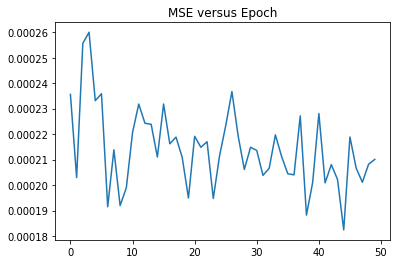

In [0]:
plt.plot(train_loss_list)
plt.title('MSE versus Epoch')

Text(0.5, 0, 'Epoch')

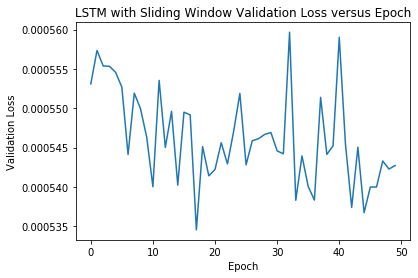

In [0]:
plt.plot(val_loss_list)
plt.title('LSTM with Sliding Window Validation Loss versus Epoch')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')

In [24]:
## If pretrained

model_lstm.load_state_dict(torch.load('Best_LSTM.pt'))

<All keys matched successfully>

In [25]:
target_list = []
prediction_list = []
model_lstm.eval()
with torch.no_grad():
    for i, (inp, target) in enumerate(data_loaders['test']):
        inp = inp.to(current_device)
        target = target.to(current_device)
        lr = model_lstm(inp.float())
        prediction_list.append(lr.view(-1))
        target_list.append(target.float().view(-1))

    prediction_tensor = torch.cat(prediction_list)
    target_tensor = torch.cat(target_list)
            
    val_loss = my_loss(prediction_tensor, target_tensor)
    print('Test customized mean square loss = {:.{prec}f}'.format(val_loss, prec=8))

    criterion_l1 = nn.L1Loss()
    val_loss_l1 = criterion_l1(prediction_tensor, target_tensor)
    print('Test mean absolute loss = {:.{prec}f}'.format(val_loss_l1, prec=8))

    val_loss_special = ((prediction_tensor - target_tensor) ** 2 / (torch.abs(target_tensor) + 1)).mean()
    print('Test special loss = {:.{prec}f}'.format(val_loss_special, prec=8))

    sign_prediction = torch.sign(prediction_tensor)
    sign_prediction[sign_prediction == 0] = 1
    sign_target = torch.sign(target_tensor)
    sign_target[sign_target == 0] = 1
    val_accuracy = ((torch.abs(sign_prediction + sign_target).sum()/2).tolist())/(sign_prediction.size()[0])
    print('Test direction accuracy = {:.{prec}f}'.format(val_accuracy, prec=8))

Test customized mean square loss = 0.00045973
Test mean absolute loss = 0.00939494
Test special loss = 0.00017422
Test direction accuracy = 0.54046053


In [26]:
# Check unique values

torch.unique(sign_prediction, return_counts = True)

(tensor([-1.,  1.], device='cuda:0'), tensor([ 672, 2368], device='cuda:0'))

In [0]:
# Compute Sharpe

sharpe_table = ffill_test[['ticker','day']].drop_duplicates()
sharpe_table = sharpe_table[sharpe_table['day'] != '2018-09-12']

In [0]:
sharpe_table['target'] = target_tensor.tolist() 
sharpe_table['price'] = prediction_tensor.tolist()
sharpe_table['not_normal_return'] = sharpe_table['target'] * sharpe_table['price']

In [0]:
return_table = sharpe_table.groupby('day', as_index = False)['not_normal_return'].sum()
return_table['normalization'] = sharpe_table.groupby('day', as_index = False)['price'].sum()['price']
return_table['return'] = return_table['not_normal_return'] / return_table['normalization']
sharpe = return_table['return'].mean() / return_table['return'].std() * np.sqrt(250)

In [30]:
print(sharpe)

3.020204781292402


In [0]:
return_plot = (return_table['return'] + 1).cumprod().tolist()
return_plot.insert(0,1)

Text(75, 0.98, 'Annual Sharpe ratio = 3.0202047')

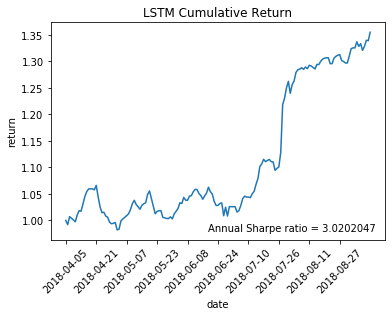

In [38]:
plt.title('LSTM Cumulative Return')
plt.xlabel('date')
plt.ylabel('return')
plt.plot(return_plot)
plt.xticks(np.arange(0,160,16), return_table['day'][0:160:16], rotation = 45)
plt.text(75, 0.98, 'Annual Sharpe ratio = 3.0202047')

In [0]:
# torch.save(model_lstm.state_dict(), 'Best_LSTM.pt')